# This project aims to analyze data from several exercise trackers (Fitbit, Garmin, Xiaomi) to study night and day time heart rate. 

Over the past 3.5 years or so I've worn a few different steps / heart rate trackers. I wanted to take a deeper look at the data over time which is what this project is all about.

Goals
1. Practice more python/matplotlib
2. Learn a little pandas
3. Learn a little SQL
4. Extract daytime resting heart rate and nighttime heart rate from multiple data sources (fitbit, garmin)

To-do
1.	Import fitbit data (json)
2.	Import garmin data 
3.	Combine into 1 sql table
4.	Calculate night time heart rate based on basic average.
5.	Come up with a measure for day time resting heart rate. 
6.  Look at how the data changes with time and correlate it with lifestyle changes.

To-do #5 is a key point. My garmin lists a daytime resting heart rate but I honestly have no idea how it gets that number. It almost appears to be the minimum day time heart rate but that's not always true. Mean is a bad measure here because there is only activity that takes you above your resting heart rate and nothing that brings you below it to average out. My first idea was to try the median. But this may not quite shift things low enough. Median might be okay if you're very sedentary, but if you get up and walk a lot or workout often it isn't a consistent enough point on the histogram. I'm thinking the 10th percentile or so of daytime heart rates may work out well. This allows for a little bit of abnormally low heart rate values while also not skewing the result due to activity.

Xiaomi was nixed from the plan because 1) I only had 4 months of data on there and 2) they don't have an API or any easy way to scrape the data.

# These are all of the modules used in this project

In [1]:
import urllib.request
import json
import sqlite3
databaseFile = 'garminHRTable.sqlite' #my database file name

import datetime 
from datetime import datetime
from datetime import timedelta
import time
from time import mktime

import numpy as np
import pandas as pd

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import fitbit
from fitbit import gather_keys_oauth2 as Oauth2 #i found this fix in a google search. manually place the .py file

# Data Gathering

## This initializes an SQL table to store our data. Just 2 columns: UNIX time in seconds and heart rate

In [ ]:
db = sqlite3.connect(databaseFile)
cursor = db.cursor()
cursor.execute('''CREATE TABLE heartrate(id INTEGER PRIMARY KEY, time INTEGER unique, heartrate INTEGER)''')
db.commit()
db.close()

## Extracting data from Garmin is pretty easy. There's a certain URL format you can type out that uses a member ID and date which gives you a JSON file of heart rate vs time. Below we iterate through a date range and check for data from the garmin website. If there is data then send it to the SQL table. After each iteration we delay 0.5s in case the server dislikes lots of data dumping. This worked fine for me when pullling ~9 months of data.

In [ ]:
memberID = '9f47d3f7-114d-446a-89d7-d0e23f6595'
trimURL = 'https://connect.garmin.com/modern/proxy/wellness-service/wellness/dailyHeartRate/'+memberID+'ad?date='
headers = {}
headers['User-Agent'] = "Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:48.0) Gecko/20100101 Firefox/48.0"

startDate = datetime(year=2019, month=9, day=17)
#endDate = datetime(year=2019, month=9, day=17)
endDate = datetime.today()
currentDate = startDate

db = sqlite3.connect(databaseFile)
cursor = db.cursor()

while currentDate <= endDate:
    dateString = currentDate.strftime('%Y-%m-%d')
    
    req = urllib.request.Request(trimURL+dateString,headers=headers)
    html = urllib.request.urlopen(req).read()
    jsonList=json.loads(html.decode('utf8').replace("'",'"'))
    hrList=jsonList['heartRateValues']
    if(type(hrList)==list):
        fixHRList=[[data[0]/1000,data[1]] for data in hrList]
        print('found data')
        for row in fixHRList:
            #need to check if the value exists yet
            cursor.execute('''SELECT time, heartrate FROM heartrate WHERE time=?''',(row[0],))
            uniqueCheck = len(cursor.fetchall())
            if(uniqueCheck == 0):
                cursor.execute('''INSERT INTO heartrate(time, heartrate) VALUES(?,?)''',(row[0],row[1])) 
    
    currentDate += timedelta(days=1)
    print(currentDate)
    db.commit() 
    time.sleep(0.5)

db.close()

## Fitbit isn't quite as easy to work with, but it's not bad. There is an API and someone already has a good writeup out there on how to use it (pasted below). I did have one issue where it wouldn't load Oauth2 so I manually pasted that python script into the fitbit folder and imported it in a different way (see module import list).
https://towardsdatascience.com/collect-your-own-fitbit-data-with-python-ff145fa10873

In [ ]:
CLIENT_ID = '22B4H7'
CLIENT_SECRET = 'fb7f7383f59d009ead9560e8b63e8318'

server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()

ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])

auth2_client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

## The cell below steps through a date range and requests data through the fitbit API. Fitbit only allows 150 requests/hour. So I put a sleep in there to allow it to keep running until finished. 

In [ ]:
startDate = datetime(year=2017, month=9, day=12)
endDate = datetime(year=2018, month=10, day=1)
#endDate = datetime.today()
currentDate = startDate

db = sqlite3.connect(databaseFile)
cursor = db.cursor()

while currentDate <= endDate:
    dateString = currentDate.strftime('%Y-%m-%d')
    
    fit_statsHR = auth2_client.intraday_time_series('activities/heart', base_date=dateString, detail_level='1sec')
    xVals = [datetime.strptime(dateString+' '+row['time'],'%Y-%m-%d %H:%M:%S') for row in fit_statsHR['activities-heart-intraday']['dataset']]
    yVals = [row['value'] for row in fit_statsHR['activities-heart-intraday']['dataset']]
    
    if(len(xVals)>100):
        print('found data')
        fixHRList = [[time.mktime(xVals[x].timetuple()),yVals[x]]for x in range(len(xVals))]
        for row in fixHRList:
            #need to check if the value exists yet
            cursor.execute('''SELECT time, heartrate FROM heartrate WHERE time=?''',(row[0],))
            uniqueCheck = len(cursor.fetchall())
            if(uniqueCheck == 0):
                cursor.execute('''INSERT INTO heartrate(time, heartrate) VALUES(?,?)''',(row[0],row[1])) 
    
    currentDate += timedelta(days=1)
    print(currentDate)
    db.commit() 
    time.sleep(30)#approx 150 requests/hour

db.close()

# Data Analysis

## So data gathering is complete. Now on to data analysis. Night time heart rate should be pretty easy... I think. We'll calculate mean and median but hopefully they're pretty similar since your heart rate should be pretty stable at night. 

## For day time, the mean and median probably will differ a good bit and that difference will vary day to day. Mean will probably be all over the place - some days I work out and some days I don't. Median may work since it will basically ignore the small amount of time your heart rate is high. If I work out for 1 hour out of 16 awake hours then that's only the top ~6 percentile of my daytime heart rate readings. Below we figure out mean and median for day and night time heart rates and put it into a dataframe.

In [199]:
sleepdf=pd.DataFrame(columns=['date','Mean Day','Median Day','Mean Night','Median Night'])
searchDateMin = datetime(year=2016, month=1, day=1)
searchDateMax = datetime.today()
currentSearchDay = searchDateMin

db = sqlite3.connect(databaseFile)
cursor = db.cursor()

while currentSearchDay < searchDateMax:
    dayStartTime = currentSearchDay + timedelta(hours=6)
    dayStartTimeUNIX = mktime(dayStartTime.timetuple())
    nightStartTime = dayStartTime + timedelta(hours=16)
    nightStartTimeUNIX = mktime(nightStartTime.timetuple())
    nightEndTime = dayStartTime + timedelta(days=1)
    nightEndTimeUNIX = mktime(nightEndTime.timetuple())
    
    cursor.execute('''SELECT * FROM heartrate WHERE time BETWEEN ? AND ?''',(dayStartTimeUNIX, nightStartTimeUNIX))
    dayData=cursor.fetchall()    
    cursor.execute('''SELECT * FROM heartrate WHERE time BETWEEN ? AND ?''',(nightStartTimeUNIX, nightEndTimeUNIX))
    nightData=cursor.fetchall()
    
    if(len(dayData)>100 and len(nightData)>100):
        dayDataTrim = [data[2] for data in dayData]
        dayDataTrim = list(filter(None, dayDataTrim))
        nightDataTrim = [data[2] for data in nightData]
        nightDataTrim = list(filter(None, nightDataTrim))
        
        sleepdf = sleepdf.append(
            {'date':currentSearchDay,
             'Mean Day':round(np.mean(dayDataTrim),1),
             'Median Day':round(np.percentile(dayDataTrim,50),1),
             'Mean Night':round(np.mean(nightDataTrim),1),
             'Median Night':round(np.median(nightDataTrim),1)
            },ignore_index=True)
    currentSearchDay+=timedelta(days=1)

db.close()
sleepdf.to_csv('processedHRData.CSV')
sleepdf = sleepdf.set_index(['date'])

## Next let's compare some data vs the various measures we calculated above. Take a day of data, plot the heart rate vs time, and then add some horizontal dotted lines that represent daytime resting heart rate and night time heart rate.

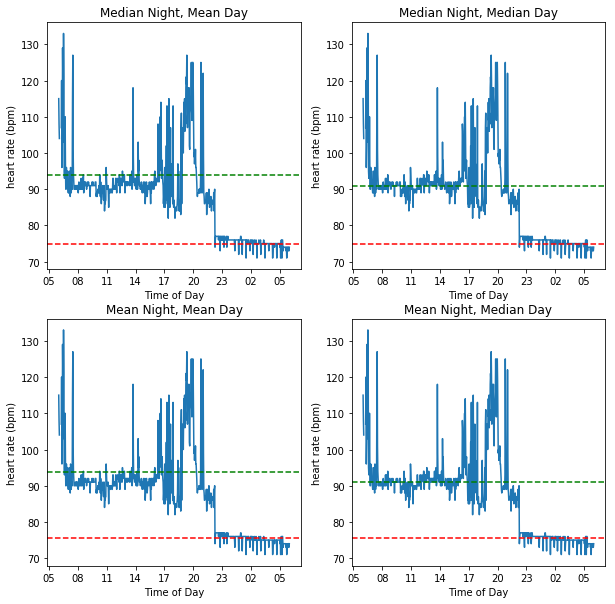

Mean Day        93.9
Median Day      91.0
Mean Night      75.6
Median Night    75.0
Name: 2019-09-12 00:00:00, dtype: float64


In [200]:
#put a date of interest into searchDateMin
searchDateMin = datetime(year=2019, month=9, day=12, hour=6)
searchDateMax = searchDateMin + timedelta(hours=24)
#format the date string to search through the data frame
dateString = searchDateMin.strftime('%Y-%m-%d')
processedValues = sleepdf.loc[dateString]
#connect to database and query
db = sqlite3.connect(databaseFile)
cursor = db.cursor()
startDateUNIX = mktime(searchDateMin.timetuple())
endDateUNIX = mktime(searchDateMax.timetuple())
cursor.execute('''SELECT * FROM heartrate WHERE time BETWEEN ? AND ?''',(startDateUNIX, endDateUNIX))
fullData=cursor.fetchall()
#the -timedelta(hours=5) below is fudging for time zone
x = [datetime(1970,1,1) + timedelta(seconds = data[1]) - timedelta(hours = 5) for data in fullData]
y = [data[2] for data in fullData]
db.close()

#now plot the data. make 4 subplots showing different combination of quantified heart rate
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax1.plot(x, y)
ax1.set(xlabel='Time of Day', ylabel='heart rate (bpm)', title='Median Night, Mean Day')
#ax1.grid()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax1.axhline(y=processedValues['Mean Day'],linestyle='--',color='g')
ax1.axhline(y=processedValues['Median Night'],linestyle='--',color='r')

ax2 = fig.add_subplot(222)
ax2.plot(x, y)
ax2.set(xlabel='Time of Day', ylabel='heart rate (bpm)', title='Median Night, Median Day')
#ax2.grid()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax2.axhline(y=processedValues['Median Day'],linestyle='--',color='g')
ax2.axhline(y=processedValues['Median Night'],linestyle='--',color='r')

ax3 = fig.add_subplot(223)
ax3.plot(x, y)
ax3.set(xlabel='Time of Day', ylabel='heart rate (bpm)', title='Mean Night, Mean Day')
#ax3.grid()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax3.axhline(y=processedValues['Mean Day'],linestyle='--',color='g')
ax3.axhline(y=processedValues['Mean Night'],linestyle='--',color='r')

ax4 = fig.add_subplot(224)
ax4.plot(x, y)
ax4.set(xlabel='Time of Day', ylabel='heart rate (bpm)', title='Mean Night, Median Day')
#ax4.grid()
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax4.axhline(y=processedValues['Median Day'],linestyle='--',color='g')
ax4.axhline(y=processedValues['Mean Night'],linestyle='--',color='r')

plt.show()
print(processedValues)

## Overall, median works well for both daytime and night time. This whole analysis assumes I sleep 10p-6a every day, which isn't true. Median allows some leeway here by ignoring the extreme ends of the histogram. Below is a cell to try plotting a few different days and overlay the day and night medians.

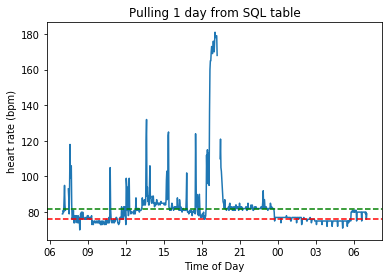

In [212]:
#put a date of interest into searchDateMin
searchDateMin = datetime(year=2019, month=1, day=29, hour=6, minute=0)
searchDateMax = searchDateMin + timedelta(hours=24)

#format the date string to search through the data frame
dateString = searchDateMin.strftime('%Y-%m-%d')
processedValues = sleepdf.loc[dateString]

#connect to database and query
db = sqlite3.connect(databaseFile)
cursor = db.cursor()
startDateUNIX = mktime(searchDateMin.timetuple())
endDateUNIX = mktime(searchDateMax.timetuple())
cursor.execute('''SELECT * FROM heartrate WHERE time BETWEEN ? AND ?''',(startDateUNIX, endDateUNIX))
fullData=cursor.fetchall()
#the -timedelta(hours=5) below is fudging for time zone
x = [datetime(1970,1,1) + timedelta(seconds = data[1]) - timedelta(hours = 5) for data in fullData]
y = [data[2] for data in fullData]
db.close()

#now plot the data
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set(xlabel='Time of Day', ylabel='heart rate (bpm)',
       title='Pulling 1 day from SQL table')
#ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.axhline(y=processedValues['Median Day'],linestyle='--',color='green')
ax.axhline(y=processedValues['Median Night'],linestyle='--',color='red')
plt.show()

## Now let's look at median day and night heart rates for 2019.

For implementing the gaussian blur I used the code from here https://matthew-brett.github.io/teaching/smoothing_intro.html.

In [206]:
def get_df_roi(dataframe,dtMin,dtMax):
    #pass in df and start and stop datetimes, return df for that time period
    searchDateMinStr = dtMin.strftime('%Y-%m-%d')
    searchDateMaxStr = dtMax.strftime('%Y-%m-%d')
    return dataframe.loc[searchDateMinStr:searchDateMaxStr]

In [217]:
def plot_df_with_blur(dataframe, column_name, new_filter_column):
    #pass in a df and a column name you want to gaussian filter. creates new filtered column and displays a plot
    #make a gaussian window and convolve with the df column. then insert convolution into the df
    sigma = 9 #2*sigma = window width
    delete_edge = sigma 
    gaussian = np.asarray([np.exp(-(x/sigma)**2/2) for x in np.arange(-sigma, sigma)])
    gaussian = gaussian/gaussian.sum()
    dataframe.insert(len(dataframe.columns),new_filter_column, np.convolve(dataframe[column_name], gaussian, mode="same"), True)
    
    #delete half the window width on the left and right and then plot
    for ind in np.concatenate((np.arange(sigma+1),np.arange(-sigma,0))):
        dataframe.at[dataframe.index[ind],new_filter_column]=np.nan
    dataframe[[column_name,new_filter_column]].plot()

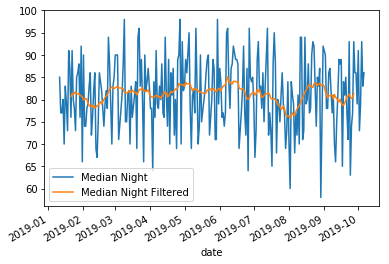

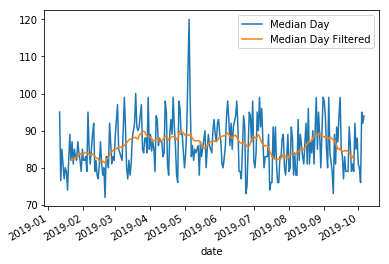

In [218]:
roi_df = get_df_roi(sleepdf,datetime(year=2019, month=1, day=1),datetime(year=2020, month=1, day=1))
plot_df_with_blur(roi_df, 'Median Night', 'Median Night Filtered')
plot_df_with_blur(roi_df, 'Median Day', 'Median Day Filtered')

## Your heart rate is expected to drop at night. This is called heart rate dip. Generally the ratio is night time <= 0.9 * daytime. If you're above that ratio it's called "nondipping" and it's correlated with bad health issues. 
https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/486862 
https://insights.ovid.com/pubmed?pmid=29517560

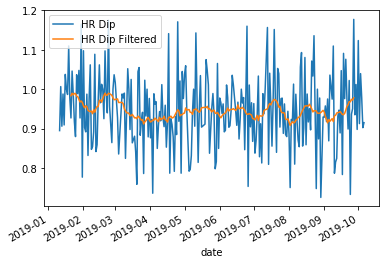

In [219]:
roi_df = get_df_roi(sleepdf,datetime(year=2019, month=1, day=1),datetime(year=2020, month=1, day=1))
roi_df.insert(len(roi_df.columns),'HR Dip', roi_df['Median Night']/roi_df['Median Day'], True)
plot_df_with_blur(roi_df, 'HR Dip', 'HR Dip Filtered')